In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
df_train.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,...,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,...,0.971,-1.489,0.530,0.917,-0.094,-1.407,0.887,-0.104,-0.583,1.267,-1.667,-2.771,-0.516,1.312,0.491,0.932,2.064,0.422,1.215,2.012,0.043,-0.307,-0.059,1.121,1.333,0.211,1.753,0.053,1.274,-0.612,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,0.183,0.459,0.478,-0.425,0.352,1.095,0.300,-1.044,0.270,-1.038,0.144,-1.658,-0.946,0.633,-0.772,1.786,0.136,-0.103,-1.223,2.273,0.055,-2.032,-0.452,0.064,0.924,-0.692,-0.067,-0.917,1.896,...,-0.540,-0.299,1.074,-0.748,1.086,-0.766,-0.931,0.432,1.345,-0.491,-1.602,-0.727,0.346,0.780,-0.527,-1.122,-0.208,-0.730,-0.302,2.535,-1.045,0.037,0.020,1.373,0.456,-0.277,1.381,1.843,0.749,0.202,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,0.274,0.335,-1.148,0.067,-1.010,1.048,-1.442,0.210,0.836,-0.326,0.716,-0.764,0.248,-1.308,2.127,0.365,0.296,-0.808,1.854,0.118,0.380,0.999,-1.171,2.798,0.394,-1.048,1.078,0.401,-0.486,...,-0.083,-0.831,1.251,-0.206,-0.933,-1.215,0.281,0.512,-0.424,0.769,0.223,-0.710,2.725,0.176,0.845,-1.226,1.527,-1.701,0.597,0.150,1.864,0.322,-0.214,1.282,0.408,-0.910,1.020,-0.299,-1.574,-1.618,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,2.198,0.190,0.453,0.494,1.478,-1.412,0.270,-1.312,-0.322,-0.688,-0.198,-0.285,1.042,-0.315,-0.478,0.024,-0.190,1.656,-0.469,-1.437,-0.581,-0.308,-0.837,-1.739,0.037,0.336,-1.102,2.371,0.554,...,-1.050,-0.347,0.904,-1.324,-0.849,3.432,0.222,0.416,0.174,-1.517,-0.337,0.055,-0.464,0.014,-1.073,0.325,-0.523,-0.692,0.190,-0.883,-1.830,1.408,2.319,1.704,-0.723,1.014,0.064,0.096,-0.775,1.845,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


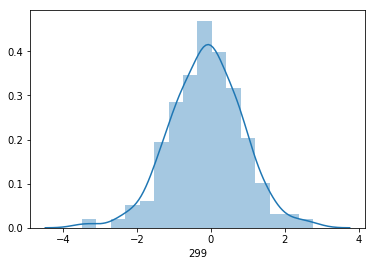

In [4]:
sns.distplot(df_train['299'])

In [5]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [10]:
train_x = np.array(df_train.iloc[:,2:])
train_t = np.array(df_train['target'])

length_of_sequences = 300
in_out_neurons = 1
hidden_neurons = 300

model = Sequential()  
model.add(LSTM(hidden_neurons, batch_input_shape=(None, length_of_sequences, in_out_neurons), return_sequences=False))  
model.add(Dense(in_out_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.fit(train_x, train_t, batch_size=600, nb_epoch=15, validation_split=0.05) 


Instructions for updating:
Colocations handled automatically by placer.


ValueError: Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (250, 300)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# rfc = RandomForestClassifier(random_state=0)

# rfc.fit(df_train.iloc[:,2:], df_train['target'])
# pred = rfc.predict(df_test.iloc[:,1:])

# submit_df = pd.DataFrame()
# submit_df['id'] = df_test['id']
# submit_df['target'] = pred
# submit_df.to_csv("submission.csv", index = False)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, seq_size, hidden_size, out_size):
        super(LSTM, self).__init__()
        self.xh = torch.nn.LSTM(seq_size, hidden_size)
        self.hy = torch.nn.Linear(hidden_size, out_size)
        self.hidden_size = hidden_size
    
    def __call__(self, xs):
        h, self.hidden = self.xh(xs, self.hidden)
        y = self.hy(h)
        return y
    
    def reset(self):
        self.hidden = (Variable(torch.zeros(1, 1, self.hidden_size)), Variable(torch.zeros(1, 1, self.hidden_size)))

EPOCH_NUM = 300
HIDDEN_SIZE = 5
BATCH_ROW_SIZE = 100
BATCH_COL_SIZE = 300
N = len(df_train)

train_x = np.array(df_train.iloc[:,2:])
train_t = np.array(df_train['target'])

# train_data = np.array([np.sin(i*2*np.pi/50) for i in range(50)]*10)
# train_x, train_t = [], []
# for i in range(0, len(train_data) - BATCH_COL_SIZE):
#     train_x.append(train_data[i:i+BATCH_COL_SIZE])
#     train_t.append(train_data[i+BATCH_COL_SIZE])
# train_x = np.array(train_x, dtype="float32")
# train_t = np.array(train_t, dtype="float32")

model = LSTM(seq_size=BATCH_COL_SIZE, hidden_size=HIDDEN_SIZE, out_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

print("Training ...")
st = datetime.datetime.now()
for epoch in range(EPOCH_NUM):
    x, t = [], []
    for i in range(BATCH_ROW_SIZE):
        index = np.random.randint(0, N)
        x.append(train_x[index])
        t.append(train_t[index])
    x = np.array(x, dtype="float64")
    t = np.array(t, dtype="float64")
    x = Variable(torch.from_numpy(x))
    t = Variable(torch.from_numpy(t))
    total_loss = 0
    model.reset()
    y = model(x)